# Ako začať s odporúčaním

In [1]:
# Na začiatku zahrnieme všetky potrebné knižnice.
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse

import time

# Na vykreslenie.
import matplotlib.pyplot as plt
from prettytable import PrettyTable

## Získanie a načítanie dát

Načítavame dátovú sadu MovieLens 1M (http://grouplens.org/datasets/movielens/1m/), ktorá obsahuje hodnotenia filmov.

*Poznámka: Dátová sada je vo formáte `dat`, pre rýchlejšie načítanie som ju previedol do formátu `CSV`.*

In [2]:
MOVIELENS_DATA = '/media/disk/data/pgaspar/movielens-1m/ratings.csv'

ratings = pd.read_csv(MOVIELENS_DATA, sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])

Náhľad dát.

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Vypočítame si základné štatistiky dátovej sady.

In [4]:
n_users = len(set(ratings['userId']))
n_items = len(set(ratings['movieId']))
n_ratings = ratings.shape[0]

print(f'''V sade je {n_users} používateľov, {n_items} filmov a {n_ratings} hodnotení.
Používatelia mohli hodnotiť filmy na škále {set(ratings['rating'])}
Spomedzi všetkých hodnôt matice hodnotení ({n_users*n_items}) je vyplnených len {n_ratings} ({round((n_ratings*100)/(n_users*n_items), 2)}%).
''')

V sade je 6040 používateľov, 3706 filmov a 1000209 hodnotení.
Používatelia mohli hodnotiť filmy na škále {1, 2, 3, 4, 5}
Spomedzi všetkých hodnôt matice hodnotení (22384240) je vyplnených len 1000209 (4.47%).



Pre každého používateľa vypočítajme počet hodnotení, priemerné hodnotenie a varianciu a vykreslime histogram pre celý dataset používateľov.

In [5]:
stats = ratings.groupby('userId')['rating'].agg(['mean', 'var', 'count'])

counts = list(stats['count'])
means = list(stats['mean'])
variances = list(stats['var'])

Tento dataset nie je vhodný pre overovanie studeného štartu. Na druhej strane, zaleží na tom, ako si studený štart zadefinujeme.

In [6]:
np.min(counts)

20

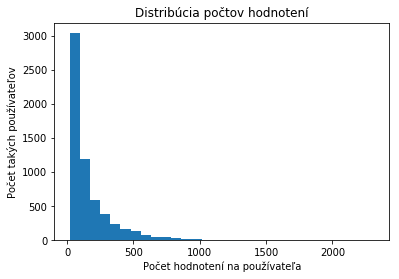

In [7]:
plt.hist(counts, bins=30)
plt.title('Distribúcia počtov hodnotení')
plt.xlabel('Počet hodnotení na používateľa')
plt.ylabel('Počet takých používateľov')
plt.show()

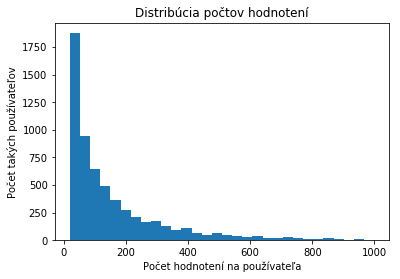

In [8]:
# Orežme o počty vyššie ako 1000.
counts_sub = np.array(counts)
counts_sub = counts_sub[counts_sub < 1000]

plt.hist(counts_sub, bins=30)
plt.title('Distribúcia počtov hodnotení')
plt.xlabel('Počet hodnotení na používateľa')
plt.ylabel('Počet takých používateľov')
plt.show()

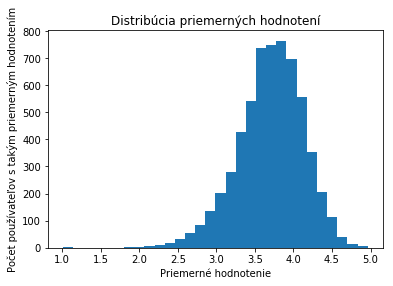

In [9]:
plt.hist(means, bins=30)
plt.title('Distribúcia priemerných hodnotení')
plt.xlabel('Priemerné hodnotenie')
plt.ylabel('Počet používateľov s takým priemerným hodnotením')
plt.show()

**Otázka:** Prečo sa má na to zmysel pozerať?

## Predspracovanie

V rámci našej úlohy budeme odporúčať filmy, pričom nás nebude zaujímať, ako by ich používateľ ohodnotil. Budeme teda skúmať, koľko z odporúčaných filmov by si človek pozrel (bez ohľadu na to, aké hodnotenie by im dal).

Inými slovami -- budeme riešiť úlohu **predpovede poradia**.

Vo fáze predspracovania chceme upraviť dataset, s ktorým pracujeme. Rozhodli sme sa, že hodnotenia na škále 1-5 prevedieme na binárne hodnotenia, kde -1 bude negatívna spätná väzba a 1 bude pozitívna spätná väzba.

### Pokus číslo 1
Nájdeme priemerné hodnotenie filmov spomedzi všetkých filmov. Hodnotenie pod túto hranicu bude negatívne. Hodnotenie nad túto hranicu bude pozitívne.

In [10]:
average_rating = ratings['rating'].mean()

print(f"Priemerné hodnotenie: {average_rating}")

Priemerné hodnotenie: 3.581564453029317


To vyzerá dobre. Teraz teda transformujeme pôvodné hodnoty zo škály 1-5 na binárne -1 a 1.

In [11]:
ratings['rating'].transform(lambda x: 1 if x >= average_rating else -1).head(10)

0    1
1   -1
2   -1
3    1
4    1
5   -1
6    1
7    1
8    1
9    1
Name: rating, dtype: int64

Môžeme si toto dovoliť? Čo ak ľudia hodnotia rôzne?

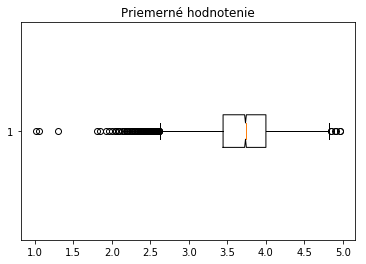

In [12]:
plt.boxplot(means, 1, 'o', 0)
plt.title('Priemerné hodnotenie')
plt.show()

### Pokus číslo 2
Rozdelíme si hodnotenia na 4 kvantily. Dolný kvartil budú pozitívne, všetko ostatné budú negatívne prípady.
**Tentokrát to ale spravíme pre každého používateľa samostatne.**

#### Odbočka - čo je to kvartil

In [13]:
# Majme vektor hodnotení.
a = [1, 1, 2, 3, 3, 2, 1, 2, 3, 2, 3, 1, 2, 5, 4, 3, 2, 5]

In [14]:
# Zoraďme ho.
a = sorted(a)
a

[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5]

In [15]:
# Vypočítajme priemer.
np.mean(a)

2.5

In [16]:
# Vypočítajme medián.
np.median(a)

2.0

In [17]:
# Čo je to vlastne medián? Hodnota uprostred zoradených hodnôt vektora.
a[int(len(a)/2)]

2

In [18]:
# Medián je 0.5 kvantil.
# Horný kvartil je 0.75 kvantil = hodnota, od ktorej je 75% hodnôt menších.
# Dolný kvartil je 0.25 kvantil = hodnota, od ktorej je 25% hodnôt menších.
print(np.percentile(a, 75))
print(np.percentile(a, 25))

3.0
2.0


In [19]:
b = [1, 2, 3, 4, 5]
print(np.percentile(b, 75))
print(np.percentile(b, 25))

4.0
2.0


Kvartil, kvantil, percentil, aký je medzi nimi vzťah?

| Kvartil| Kvantil | Percentil |
| ----------- |
| 0 kvartil | 0.00 kvantil | 0 percentil |
| 1 kvartil | 0.25 kvantil | 25 percentil |
| 2 kvartil | 0.50 kvantil | 50 percentil |
| 3 kvartil | 0.75 kvantil | 75 percentil |
| 4 kvartil | 1.00 kvantil | 100 percentil |

https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html

#### Koniec odbočky

In [20]:
# Pripravíme si funkciu na výpočet kvantilov.
# https://stackoverflow.com/a/17578653
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'quantile_%s' % n
    return percentile_

In [21]:
# Pre každého používateľa získame dolný kvartil hodnotení.
rating_quantiles = ratings.groupby('userId')['rating'].agg([percentile(25)])

Čo ak majú používatelia menej ako určitý počet hodnotení? Vtedy sa nemôžeme spoliehať na ich kvartily, ale môžeme použiť priemerný kvartil naprieč všetkými používateľmi.

In [22]:
ratings['rating'].quantile(.25)

3.0

Teraz upravíme hodnotenia používateľov.

In [23]:
ratings = pd.merge(ratings, rating_quantiles, left_on='userId', right_index=True)

ratings['rating_norm'] = 0 # Predvolená hodnota.

ratings.loc[ratings['rating'] < ratings['quantile_25'], 'rating_norm'] = -1
ratings.loc[ratings['rating'] >= ratings['quantile_25'], 'rating_norm'] = 1

In [24]:
ratings.head(10)

,userId,movieId,rating,timestamp,quantile_25,rating_norm
0,1,1193,5,978300760,4.0,1
1,1,661,3,978302109,4.0,-1
2,1,914,3,978301968,4.0,-1
3,1,3408,4,978300275,4.0,1
4,1,2355,5,978824291,4.0,1
5,1,1197,3,978302268,4.0,-1
6,1,1287,5,978302039,4.0,1
7,1,2804,5,978300719,4.0,1
8,1,594,4,978302268,4.0,1
9,1,919,4,978301368,4.0,1


Teraz sa pozrieme na to, koľko máme pozitívnej a negatívnej spätnej väzby.

In [25]:
ratings.groupby('rating_norm')['rating'].count()

rating_norm
-1    139414
 1    860795
Name: rating, dtype: int64

In [26]:
# Odstranime nepotrebne.
del ratings['quantile_25']
ratings['rating'] = ratings['rating_norm']
del ratings['rating_norm']

## Rozdelenie dát na train a test

In [27]:
ratings = pd.read_csv(MOVIELENS_DATA, sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])

Aby sme vedeli overiť náš odporúčač, potrebujeme mať dáta rozdelené na trénovaciu a testovaciu množinu. V prípade odporúčania môže nastať ale problém. Skúsme najskôr použiť to, čo nám ponúka Python knižnica `scipy`.

Vytvoríme si maticu, v ktorej riadky budú používatelia a stĺpce budú filmy.

In [28]:
ratings_pivot = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
sparce_rating_matrix = sp.sparse.csr_matrix(ratings_pivot.values)

In [29]:
print(f"Rozmery matice hodnotení: {sparce_rating_matrix.shape}")
print(f"Počet používateľov: {n_users}\nPočet filmov: {n_items}")

Rozmery matice hodnotení: (6040, 3706)
Počet používateľov: 6040
Počet filmov: 3706


Použijeme metódu `train_test_split`, ktorá rozdeľuje dáta na trénovacie a testovacie.

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
data_train, data_test = train_test_split(sparce_rating_matrix, test_size=0.2)

print(f'''Rozmery trénovacej množiny: {data_train.shape}
Rozmery testovacej množiny: {data_test.shape}''')

Rozmery trénovacej množiny: (4832, 3706)
Rozmery testovacej množiny: (1208, 3706)


Metóda rozdelila hodnotenia po používateľoch. **Prečo?**

Vyskúšame teda rozdeliť samotný DataFrame s hodnoteniami.

In [32]:
train_df, test_df = train_test_split(ratings, test_size=0.2)

In [33]:
# Overíme, či sa množina používateľov v train a teste prekrýva.
intersection_users = len(np.intersect1d(list(set(train_df['userId'])), list(set(test_df['userId']))))
print(f"Z celkového počtu {n_users} používateľov máme zároveň v traine aj v teste {intersection_users}.")

Z celkového počtu 6040 používateľov máme zároveň v traine aj v teste 6037.


### Diskusia

**Otázka na zamyslenie č. 1:**
Ako rozdeľovať interakcie používateľa s položkami (napr. hodnotenie, nákup, návšteva) na trénovaciu a testovaciu množinu (nemusí platiť len pri úlohe odporúčania)?

**Otázka na zamyslenie č. 2**:
Ako tento postup obohatiť o validačnú sadu?

## Vytvorenie matice hodnotení

Maticu budeme potrebovať iba pre účely trénovania modelu odporúčania. Pre testovanie si vystačíme s dataframom, z ktorého budeme získavať filmy, ktoré používateľ pozeral.

In [34]:
ratings = pd.read_csv(MOVIELENS_DATA, sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])

train_df, test_df = train_test_split(ratings, test_size=0.2)

# Normalizujeme hodnotenia v traine (vid vyssie).
rating_quantiles = train_df.groupby('userId')['rating'].agg([percentile(25)])
train_df = pd.merge(train_df, rating_quantiles, left_on='userId', right_index=True)

train_df['rating_norm'] = 0 # Predvolená hodnota.

train_df.loc[train_df['rating'] < train_df['quantile_25'], 'rating_norm'] = -1
train_df.loc[train_df['rating'] >= train_df['quantile_25'], 'rating_norm'] = 1

# Odstranime nepotrebne.
del train_df['quantile_25']
train_df['rating'] = train_df['rating_norm']
del train_df['rating_norm']

In [35]:
ratings_pivot = train_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
sparce_rating_matrix = sp.sparse.csr_matrix(ratings_pivot.values)

In [36]:
print(f"Rozmery matice hodnotení: {sparce_rating_matrix.shape}")
print(f"Počet používateľov: {n_users}\nPočet filmov: {n_items}")

Rozmery matice hodnotení: (6040, 3686)
Počet používateľov: 6040
Počet filmov: 3706


Tuší niekto, aký tu môže byť problém?

In [37]:
unique_users = np.array(list(set(ratings['userId'])))
unique_items = np.array(list(set(ratings['movieId'])))

# Chýbajúce ID používateľov.
print(len(np.setdiff1d(unique_users, list(ratings_pivot.index))))

# Chýbajúce ID filmov.
print(len(np.setdiff1d(unique_items, list(ratings_pivot.columns))))

0
20


Niektoré odporúčače môžu mať problém s tým, ak v matici chýbajú položky, ktoré síce ohodnotené nie sú, ale môžeme ich odporúčať (hybridné odporúčanie s obsahom).

Tento problém môžeme vyriešiť jednoduchým pridaním fiktívneho používateľa, ktorý ohodnotil všetky chýbajúce filmy.

In [38]:
train_df = train_df.copy()

max_i = np.max(list(train_df.index))
for item_id in np.setdiff1d(unique_items, list(ratings_pivot.columns)):
    max_i += 1
    train_df.at[max_i] = { 'userId': -1, 'movieId': item_id, 'rating': -2 }

In [39]:
train_df.tail()

,userId,movieId,rating,timestamp
1000224,-1.0,3220.0,-2.0,NaN
1000225,-1.0,3297.0,-2.0,NaN
1000226,-1.0,3312.0,-2.0,NaN
1000227,-1.0,3607.0,-2.0,NaN
1000228,-1.0,3904.0,-2.0,NaN


Teraz už môžeme vytvoriť novú pivot table a maticu pre odporúčanie. A použijeme priamo normalizované hodnotenie.

In [40]:
ratings_pivot = train_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

# Odstránime fiktívneho používateľa.
ratings_pivot.drop(-1, axis=0, inplace=True)

# Vytvorenie matice.
sparce_rating_matrix = sp.sparse.csr_matrix(ratings_pivot.values)

In [41]:
print(f"Rozmery matice hodnotení: {sparce_rating_matrix.shape}")
print(f"Počet používateľov: {n_users}\nPočet filmov: {n_items}")

Rozmery matice hodnotení: (6040, 3706)
Počet používateľov: 6040
Počet filmov: 3706


In [42]:
# Chýbajúce ID používateľov.
print(len(np.setdiff1d(unique_users, list(ratings_pivot.index))))

# Chýbajúce ID filmov.
print(len(np.setdiff1d(unique_items, list(ratings_pivot.columns))))

0
0


### Poznámka k vytváraniu matice

Metóda `pivot` DataFrame je časovo aj pamäťovo veľmi náročná operácia. Ak nepotrebujete skúmať maticu hodnotení, ktorú `pivot` vygeneruje, odporúčam použiť nasledujúce zjednodušenie. Hoci je to menej transparentný postup, dosiahnete rovnaký výsledok a navyše rýchlejšie.

Zdroj: https://stackoverflow.com/a/41133881

In [43]:
user_u = list(sorted(train_df.userId.unique()))
item_u = list(sorted(train_df.movieId.unique()))

row = train_df.userId.astype(pd.api.types.CategoricalDtype(categories=user_u)).cat.codes
col = train_df.movieId.astype(pd.api.types.CategoricalDtype(categories=item_u)).cat.codes

data = train_df['rating'].tolist()

sparce_rating_matrix_alt = sp.sparse.csr_matrix((data, (row, col)), shape=(len(user_u), len(item_u)))

In [44]:
# Odstranenie fiktivnych hodnoteni.
sparce_rating_matrix_alt = sp.sparse.csr_matrix(np.delete(sparce_rating_matrix_alt.toarray(), 0, axis=0))

In [45]:
sparce_rating_matrix

<6040x3706 sparse matrix of type '<class 'numpy.float64'>'
	with 800167 stored elements in Compressed Sparse Row format>

In [46]:
sparce_rating_matrix_alt

<6040x3706 sparse matrix of type '<class 'numpy.float64'>'
	with 800167 stored elements in Compressed Sparse Row format>

## Odporúčanie pomocou knižnice LightFM

Vytvorenú maticu teraz použijeme priamo pre odporúčanie.

In [47]:
from lightfm import LightFM

In [48]:
ratings_pivot.tail()

movieId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,3943.0,3944.0,3945.0,3946.0,3947.0,3948.0,3949.0,3950.0,3951.0,3952.0
userId,,,,,,,,,,,,,,,,,,,,,
6036.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6039.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6040.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Natrénujeme model LightFM s predvolenými parametrami, pričom trénujeme priamo na matici hodnotení.

Kto by sa chcel pohrať s parametrami, odporúčam [pozrieť dokumentáciu](http://lyst.github.io/lightfm/docs/home.html).

In [49]:
model = LightFM(loss='warp-kos', learning_schedule = "adadelta", no_components = 5)

# Natrénovanie modelu (môže chvíľu trvať).
model.fit(sparce_rating_matrix, epochs=20)

A teraz hor sa do odporúčania!

Vyskúšame si to najskôr na používateľovi **na prvom riadku matice hodnotení**.

Metóda `predict` prijíma ako prvý parameter _index riadku matice hodnotení_ (t.j. index používateľa). Druhým parametrom je _zoznam položiek, pre ktorého chceme vedieť **poradie**_ (t.j. zoznam filmov). My budeme žiadať poradie pre všetky filmy, ktoré máme k dispozícii.

In [50]:
user_id = unique_users[0]

In [51]:
predictions = model.predict(user_id, np.arange(len(unique_items)))
predictions

array([ -5.5218997 ,  -8.37373161,  -9.82261848, ..., -10.73168087,
       -11.04235363,  -8.04077435])

Hmm... zaujímavé čísielka. Ako zistíme TOP 10 narelevantnejších filmov?

In [52]:
np.argsort(-predictions)[:10]

array([1478,  443, 1384, 1848,  699, 2086,   20,  106,  339,  367])

Treba si uvedomiť, že toto sú stále indexy v matici hodnotení, čiže **nie ID filmov z nášho datasetu**. Tie ale získame pomerne jednoducho:

In [53]:
predictions_movieIds = unique_items[np.argsort(-predictions)[:10]]
predictions_movieIds

array([1610,  457, 1500, 2028,  733, 2278,   21,  110,  349,  377])

A nakoľko sme boli úspešní? Pozrime sa do testu pre používateľa.

In [54]:
user_test = list(test_df[test_df['userId'] == unique_users[user_id]]['movieId'])
print(f"Testovacia množina používateľa: {user_test}")
print(f"Prienik s odporúčaním: {np.intersect1d(user_test, predictions_movieIds)}")

Testovacia množina používateľa: [1962, 1954, 1784, 1210, 1370, 2028, 1244, 442, 3809, 1253, 1265, 318, 2728, 2268, 1597, 1957, 2943, 2278, 1217, 1442, 589, 165, 1225, 920, 457]
Prienik s odporúčaním: [ 457 2028 2278]


Tuší niekto, aká zrada tu mohla nastať?

In [55]:
user_train = list(train_df[train_df['userId'] == unique_users[user_id]]['movieId'])
print(f"Trénovacia množina používateľa:\n{user_train}\n")
print(f"Prienik s odporúčaním: {np.intersect1d(user_train, predictions_movieIds)}")

Trénovacia množina používateľa:
[1527.0, 95.0, 647.0, 1124.0, 2353.0, 1293.0, 2126.0, 3071.0, 3147.0, 3257.0, 2881.0, 459.0, 1917.0, 3471.0, 982.0, 3035.0, 1945.0, 2628.0, 1953.0, 2858.0, 1537.0, 2852.0, 1188.0, 21.0, 1544.0, 1408.0, 1834.0, 235.0, 593.0, 2501.0, 515.0, 3108.0, 3255.0, 1103.0, 1968.0, 2006.0, 3678.0, 1357.0, 3107.0, 2571.0, 2236.0, 3256.0, 3654.0, 1610.0, 3030.0, 2067.0, 1198.0, 1084.0, 368.0, 2312.0, 2916.0, 1687.0, 3418.0, 110.0, 1213.0, 356.0, 736.0, 902.0, 2490.0, 3334.0, 3468.0, 2359.0, 3105.0, 1552.0, 590.0, 292.0, 1792.0, 1096.0, 1372.0, 1245.0, 2717.0, 2321.0, 1955.0, 648.0, 1207.0, 163.0, 1801.0, 380.0, 498.0, 480.0, 3893.0, 2396.0, 1196.0, 1385.0, 3095.0, 2194.0, 1259.0, 1873.0, 1690.0, 2427.0, 1090.0, 1247.0, 265.0, 3578.0, 2002.0, 434.0, 3735.0, 3699.0, 1193.0, 3068.0, 780.0, 1246.0, 349.0, 3451.0]

Prienik s odporúčaním: [  21.  110.  349. 1610.]


Do predikcie sa nám prebojovalo niekoľko filmov, ktoré už používateľ ohodnotili. **Vzhľadom na povahu datasetu** nám to skresľuje výsledok.

Riešenie je opäť jednoduché. Po vygenerovaní poradia nastavme na tých indexoch, ktoré reprezentujú položky z trénovacej množiny, nízke hodnoty. Čiže do Top $N$ poradia sa nikdy nedostanú (ak nebude $N$ zhodné s počtom všetkých filmov).

In [56]:
# Ziskame indexy filmov, ktore mame pre pouzivatela v traine.
user_train_indexes = np.where(np.in1d(unique_items, user_train))

# Vygenerujeme predikciu poradia.
predictions_new = model.predict(user_id, np.arange(len(unique_items)))

# Na tie miesta, kde sa nachadzaju filmy z trenovacej mnoziny, vlozime zaporne hodnoty.
np.put(predictions_new, user_train_indexes, np.min(predictions_new)-1)

Napadá niekomu, ako sa dá urobiť ešte inak?

In [57]:
# Porovname povodne predikcie s novymi, ktore neobsahuju filmy z trainu pouzivatela.
predictions_new_movieIds = unique_items[np.argsort(-predictions_new)[:10]]
print(predictions_movieIds)
print(predictions_new_movieIds)

[1610  457 1500 2028  733 2278   21  110  349  377]
[ 457 1500 2028  733 2278  377   50 1265  474 1580]


Nové odporúčania sa už líšia. Porovnajme teda presnosť s predchádzajúcim.

In [58]:
print(f"Testovacia množina používateľa: {user_test}")
print(f"Prienik pôvodného s odporúčaním: {np.intersect1d(user_test, predictions_movieIds)}")
print(f"Prienik upraveného s odporúčaním: {np.intersect1d(user_test, predictions_new_movieIds)}")

Testovacia množina používateľa: [1962, 1954, 1784, 1210, 1370, 2028, 1244, 442, 3809, 1253, 1265, 318, 2728, 2268, 1597, 1957, 2943, 2278, 1217, 1442, 589, 165, 1225, 920, 457]
Prienik pôvodného s odporúčaním: [ 457 2028 2278]
Prienik upraveného s odporúčaním: [ 457 1265 2028 2278]


Pre kontrolu.

In [59]:
print(f"Prienik trénovacej množiny s odporúčaním: {np.intersect1d(user_train, predictions_new_movieIds)}")

Prienik trénovacej množiny s odporúčaním: []


Budeme odporúčať pre každého používateľa v testovacej množine. **Pozor!** Nemôžeme pracovať priamo s ID používateľa z testovacej množiny, ale musíme získať ich indexy v matici.

In [60]:
# Metóda vráti odporúčané položky, skutočne hodnotené filmy a veľkosť trénovacej množiny.
def recommend(model, train_df, test_df, user_id, n = 10):
    
    # Potrebujeme ID používateľa, ktoré je prítomné v dataframe s hodnotením.
    user_real_id = unique_users[user_id]
    
    # Získame filmy z trainu.
    user_train = list(train_df[train_df['userId'] == user_real_id]['movieId'])
    user_train_indexes = np.where(np.in1d(unique_items, user_train))[0]
    
    # Získame filmy z testu.
    user_test = list(test_df[test_df['userId'] == user_real_id]['movieId'])
    
    # Vykonáme predikciu poradia.
    predictions = model.predict(user_id, np.arange(len(unique_items)))
    np.put(predictions, user_train_indexes, np.min(predictions)-1)

    return [unique_items[np.argsort(-predictions)[:n]], user_test, len(user_train)]    

In [61]:
# Pripravíme si zoznam používateľov z testovacej množiny.
user_ids_test = list(test_df['userId'])
users_to_test = np.where(np.in1d(unique_users, user_ids_test))[0]
len(users_to_test)

6034

Teraz postupne pre každého používateľa vykonáme odporúčanie. Zároveň si odmeriame, koľko to bude trvať a vypočítame presnosť odporúčania.

In [62]:
recommendations = []
precision = []

start = time.time()
for user_id in users_to_test:
    
    recommendation = recommend(model, train_df, test_df, user_id)
    recommendations.append(recommendation)
    precision.append(len(np.intersect1d(recommendation[0], recommendation[1])) / 10)
    
elapsed_time = time.time() - start

In [63]:
print(f"Priemerná presnosť: {round(np.mean(precision), 4)}")
print(f"Trvanie odporúčania: {elapsed_time} sekúnd.")

Priemerná presnosť: 0.2637
Trvanie odporúčania: 27.437376022338867 sekúnd.


## Odporúčanie je pomalé. Čo s tým?

In [64]:
import multiprocessing
from multiprocessing import Pool

num_workers = 15 # Koresponduje s poctom jadier, ale je dobre jedno nechat bokom.

In [65]:
print(f"Priemerná presnosť: {round(np.mean(precision), 4)}")
print(f"Trvanie odporúčania {round(elapsed_time, 2)} sekund.")

Priemerná presnosť: 0.2637
Trvanie odporúčania 27.44 sekund.


In [66]:
final_results = None

# Funkcia, ktorú spúšťame paralelne na každého používateľa.
def evaluate_recommendations(user_id):
    recommendation = recommend(model, train_df, test_df, user_id)
    precision = len(np.intersect1d(recommendation[0], recommendation[1])) / 10
    
    return [recommendation, precision]

start = time.time()
with Pool(num_workers) as p:
    # Na každého používateľa v teste zavoláme funkciu evaluate_recommendations.
    final_results = p.map(evaluate_recommendations, users_to_test)
elapsed_time = time.time() - start

precision = np.mean([x[1] for x in final_results])
print(f"Priemerna presnost: {precision}")
print(f"Odporucanie s paralelizaciou trva {round(elapsed_time, 2)} sekund.")

Priemerna presnost: 0.26365594961882666
Odporucanie s paralelizaciou trva 4.99 sekund.


## Vyhodnotenie kvality odporúčania

Teraz sa na samotné vyhodnotenie ešte pozrieme podrobnejšie.

Problém štandardných Python knižníc je ten, že výpočet presnosti zakladajú na úlohách klasifikácie ani regresie. Tu, ale nejde o klasifikáciu, ani regresiu, snažíme sa **predikovať poradie**. Využívame teda metriky z oblasti vyhľadávania informácií.

Pokiaľ nevyužijeme knižnice na odporúčanie, ktoré tieto metriky ponúkajú, musíme si ich pripraviť sami :)

Odporúčam link:
https://gist.github.com/bwhite/3726239

### Presnosť, pokrytie, F1-skóre

In [67]:
def precision_at_k(predicted, true, k = 10, n = 10):
    return (len(np.intersect1d(predicted[:k], true)) / n)

def recall_at_k(predicted, true, k = 10):
    return (len(np.intersect1d(predicted[:k], true)) / len(true))

def f1_measure_at_k(predicted, true, n = 10):
    prec = precision_at_k(predicted, true, n)
    rec = recall_at_k(predicted, true)
    return (2*prec*rec)/(prec + rec)

Ukážeme si na príklade.

In [68]:
predicted = [1, 2, 3]
test = [1, 4, 5, 6]

print("Presnosť: {:0.2f}\nPokrytie: {:0.2f}\nF1-skóre: {:0.2f}".\
      format(precision_at_k(predicted, test), recall_at_k(predicted, test), f1_measure_at_k(predicted, test)))

Presnosť: 0.10
Pokrytie: 0.25
F1-skóre: 0.14


Pri predpovedaní poradia nás zaujíma, na ktorom mieste boli relevantné výsledky. Čím vyššie, tým lepšie.

In [69]:
def average_precision(predicted, true):
    # Zaujimaju nas pozicie, kde sme sa trafili.
    positions = np.isin(predicted, test)
    
    precisions = [precision_at_k(predicted, test, k+1, k+1) for k in range(positions.size) if positions[k]]
    
    if len(precisions) > 0:
        return np.mean(precisions)
    else:
        return 0.

In [70]:
# Budeme posuvat poziciu 1, ktora je "spravna".
predicted = [
    [1, 2, 3],
    [2, 1, 3],
    [2, 3, 1]
]

for pr in predicted:
    print("Priemerná presnosť pre {} = {:0.2f}".format(pr, average_precision(pr, test)))

Priemerná presnosť pre [1, 2, 3] = 1.00
Priemerná presnosť pre [2, 1, 3] = 0.50
Priemerná presnosť pre [2, 3, 1] = 0.33


Ďalšie metriky v Pythone nájdete napríklad tu: https://gist.github.com/bwhite/3726239

Na čo si dať pozor:
- pri vyhodnocovaní kvality odporúčania nevyhodnocujte nad trénovacími, ale nad testovacími dátami. Trénovacie dáta používajte len na trénovanie, veď na to sú aj určené,
- treba si uvedomiť (a to nielen pri odporúčaní), že tieto metriky uvádzajú **najhorší** výsledok,
- častokrát presnosť alebo úplnosť nie je všetko - záleží to od domény a od úlohy,
- nikdy neskúmajte len jednu metriku, ale zvoľte si ich viac - opäť, záleží od domény a od úlohy.

### Testovanie parametrov

**Upozornenie:** Pri testovaní parametrov nikdy nezabudnite rozdeliť dáta na trénovaciu, validačnú a testovaciu množinu. Parametre testujte pomocou trénovacej a validačnej množiny. Testovaciu použite na finálne overenie zvolených najlepších parametrov.

**Poznámka:** Pri testovaní parametrov je viac než vhodné vykonať n-fold cross validáciu. Na nižšie uvedenom príklade to ukazujem bez nej.

Knižnica [LightFM](http://lyst.github.io/lightfm/docs/lightfm.html) podporuje 4 typy rôznych stratových funkcií (viď. [dokumentáciu](http://lyst.github.io/lightfm/docs/lightfm.html)). Otestujme, akú kvalitu bude dosahovať odporúčač pri týchto typoch stratových funkcií.

In [71]:
model_losses = ['logistic', 'bpr', 'warp', 'warp-kos']

# Inicializujeme jednotlive modely na zaklade zvolenej stratovej funkcie.
models = {}
for loss in model_losses:
    models[loss] = LightFM(loss=loss, learning_schedule = "adadelta", no_components = 5)

# Vsetky modely natrenujeme.
[model.fit(sparce_rating_matrix, epochs=20) for model in models.values()]

Postupne necháme každý model vygenerovať odporúčanie a pre každý model tiež vypočítame jeho presnosť a úplnosť.

In [72]:
final_results = {}

def evaluate_recommendations(setup):
    model, user_id = setup
    
    recommendation = recommend(model, train_df, test_df, user_id)
    precision_score = precision_at_k(recommendation[0], recommendation[1])
    recall_score = recall_at_k(recommendation[0], recommendation[1])
    
    return [recommendation, precision_score, recall_score]

results = PrettyTable(['Model', 'Presnost', 'Pokrytie'])

for model_name, model in models.items():
    
    with Pool(num_workers) as p:
        setup = [[model, user_id] for user_id in users_to_test]
        
        final_results = p.map(evaluate_recommendations, setup)
    
    precision = np.mean([x[1] for x in final_results])
    recall = np.mean([x[2] for x in final_results])
    results.add_row([model_name, round(precision, 4), round(recall, 4)])
    
print(results)

+----------+----------+----------+
|  Model   | Presnost | Pokrytie |
+----------+----------+----------+
| logistic |  0.0546  |  0.0201  |
|   bpr    |  0.1992  |  0.0838  |
|   warp   |  0.2864  |  0.1159  |
| warp-kos |  0.2598  |  0.1074  |
+----------+----------+----------+


Skúsme zafixovať model, ale budeme meniť počet komponentov modelu.

In [73]:
loss = 'warp'
no_components_range = np.arange(5, 30) # The dimensionality of the feature latent embeddings.

# Inicializujeme jednotlive modely na zaklade zvolenej stratovej funkcie.
models = []
for no_components in no_components_range:
    models.append(LightFM(loss=loss, learning_schedule = "adadelta", no_components = no_components))

# Vsetky modely natrenujeme (tu uz vyuzijeme viac jadier, kedze inak by to trvalo privelmi dlho).
def fit_model(model):
    model.fit(sparce_rating_matrix, epochs=20)
    return model

with Pool(num_workers) as p:
    models = p.map(fit_model, models)

In [74]:
final_results = {}
results = []

for model in models:
    
    with Pool(num_workers) as p:
        setup = [[model, user_id] for user_id in users_to_test]
        
        final_results = p.map(evaluate_recommendations, setup)
    
    precision = np.mean([x[1] for x in final_results])
    recall = np.mean([x[2] for x in final_results])
    results.append([model.no_components, round(precision, 4), round(recall, 4)])
    
results_table = PrettyTable(['Pocet komponentov', 'Presnost', 'Pokrytie'])
[results_table.add_row(result) for result in results]

print(results_table)

+-------------------+----------+----------+
| Pocet komponentov | Presnost | Pokrytie |
+-------------------+----------+----------+
|         5         |  0.2823  |  0.1142  |
|         6         |  0.2966  |  0.1224  |
|         7         |  0.3013  |  0.1258  |
|         8         |  0.3092  |  0.1309  |
|         9         |  0.3129  |  0.1324  |
|         10        |  0.3172  |  0.1352  |
|         11        |  0.3234  |  0.1393  |
|         12        |  0.323   |  0.139   |
|         13        |  0.324   |  0.1403  |
|         14        |  0.3287  |  0.1448  |
|         15        |  0.328   |  0.1425  |
|         16        |  0.3298  |  0.1431  |
|         17        |  0.3289  |  0.1423  |
|         18        |  0.3297  |  0.1443  |
|         19        |  0.3289  |  0.1447  |
|         20        |  0.3289  |  0.1452  |
|         21        |   0.33   |  0.1455  |
|         22        |  0.3314  |  0.1468  |
|         23        |  0.3301  |  0.1453  |
|         24        |  0.3309  |

Vykreslime presnosť a pokrytie do grafu.

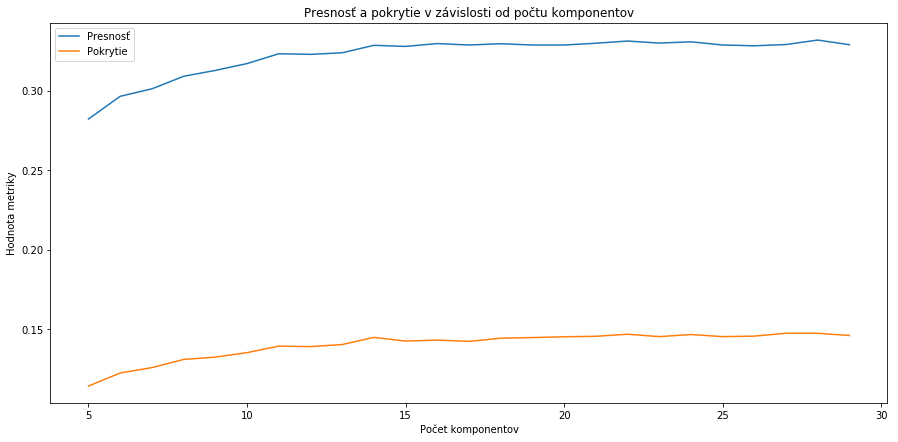

In [75]:
x = np.array(results)[:, 0]
y = np.array(results)[:, 1:]

fig = plt.figure(figsize=(15,7))

plt.plot(x, y[:, 0], label="Presnosť")
plt.plot(x, y[:, 1], label="Pokrytie")
plt.legend(loc=2)
plt.title('Presnosť a pokrytie v závislosti od počtu komponentov')
plt.xlabel('Počet komponentov')
plt.ylabel('Hodnota metriky')
    
plt.show()

## Bez normalizácie hodnotenia
A čo by sa stalo, kebyže neurobíme normalizáciu na začiatku?

In [76]:
ratings = pd.read_csv(MOVIELENS_DATA, sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])

train_df, test_df = train_test_split(ratings, test_size=0.2)

train_df = train_df.copy()
train_df['rating_norm'] = 1

rating_quantiles = train_df.groupby('userId')['rating'].agg([percentile(25)])
train_df = pd.merge(train_df, rating_quantiles, left_on='userId', right_index=True)
train_df['rating_norm'] = 0 # Predvolená hodnota.
train_df.loc[train_df['rating'] < train_df['quantile_25'], 'rating_norm'] = -1
train_df.loc[train_df['rating'] >= train_df['quantile_25'], 'rating_norm'] = 1

del train_df['quantile_25']
del train_df['timestamp']

In [77]:
# Vytvorenie dat bez normalizacie.
train_df_orig = train_df.copy()
del train_df_orig['rating_norm']
ratings_pivot_orig = train_df_orig.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

max_i = np.max(list(train_df_orig.index))
for item_id in np.setdiff1d(unique_items, list(ratings_pivot_orig.columns)):
    max_i += 1
    train_df_orig.at[max_i] = { 'userId': -1, 'movieId': item_id, 'rating': -2 }

ratings_pivot_orig = train_df_orig.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
ratings_pivot_orig.drop(-1, axis=0, inplace=True)
sparce_rating_matrix_orig = sp.sparse.csr_matrix(ratings_pivot_orig.values)

In [78]:
# Vytvorenie dat s normalizaciou.
train_df_norm = train_df.copy()
del train_df_norm['rating']
ratings_pivot_norm = train_df_norm.pivot(index = 'userId', columns ='movieId', values = 'rating_norm').fillna(0)

max_i = np.max(list(train_df_norm.index))
for item_id in np.setdiff1d(unique_items, list(ratings_pivot_norm.columns)):
    max_i += 1
    train_df_norm.at[max_i] = { 'userId': -1, 'movieId': item_id, 'rating_norm': -2 }

ratings_pivot_norm = train_df_norm.pivot(index = 'userId', columns ='movieId', values = 'rating_norm').fillna(0)
ratings_pivot_norm.drop(-1, axis=0, inplace=True)
sparce_rating_matrix_norm = sp.sparse.csr_matrix(ratings_pivot_norm.values)

In [79]:
model_orig = LightFM(loss='warp-kos', learning_schedule = "adadelta", no_components = 5)
model_norm = LightFM(loss='warp-kos', learning_schedule = "adadelta", no_components = 5)

model_orig.fit(sparce_rating_matrix_orig, epochs=20)
model_norm.fit(sparce_rating_matrix_norm, epochs=20)

In [80]:
final_results = {}

user_ids_test = list(test_df['userId'])
users_to_test = np.where(np.in1d(unique_users, user_ids_test))[0]

def evaluate_recommendations(setup):
    model, train_df, test_fd, user_id = setup
    
    recommendation = recommend(model, train_df, test_df, user_id)
    precision_score = precision_at_k(recommendation[0], recommendation[1])
    recall_score = recall_at_k(recommendation[0], recommendation[1])
    
    return [recommendation, precision_score, recall_score]

# Vyhodnotenie odporucaca bez normalizacie.
with Pool(num_workers) as p:
    setup = [[model_orig, train_df_orig, test_df, user_id] for user_id in users_to_test]
    final_results['orig'] = p.map(evaluate_recommendations, setup)
    
# Vyhodnotenie odporucaca s normalizaciou.
with Pool(num_workers) as p:
    setup = [[model_norm, train_df_norm, test_df, user_id] for user_id in users_to_test]
    final_results['norm'] = p.map(evaluate_recommendations, setup)

precision_orig = np.mean([x[1] for x in final_results['orig']])
precision_norm = np.mean([x[1] for x in final_results['norm']])
recall_orig = np.mean([x[2] for x in final_results['orig']])
recall_norm = np.mean([x[2] for x in final_results['norm']])

print(f"Priemerna presnost (povodne): {precision_orig}")
print(f"Priemerna presnost (normalizovane): {precision_norm}\n")
print(f"Priemerna recall (povodne): {recall_orig}")
print(f"Priemerna recall (normalizovane): {recall_norm}")

Priemerna presnost (povodne): 0.26397217160841474
Priemerna presnost (normalizovane): 0.26975318866986914

Priemerna recall (povodne): 0.1095555060208631
Priemerna recall (normalizovane): 0.10990552223289092


### Bonus pre fajnšmekrov

Sú vypočítané hodnoty presnosti skutočne *signifikantne* rozdielne?

In [81]:
import scipy.stats

In [82]:
precisions_orig = [x[1] for x in final_results['orig']]
precisions_norm = [x[1] for x in final_results['norm']]

In [83]:
print(np.var(precisions_orig))
print(np.var(precisions_norm))

0.057683277675141656
0.059611882102222645


Použijeme štatistický t-test, ktorý nám pomôže odhaliť, či majú dve populácie (dva odporúčače) rovnaké očakávané hodnoty (v tomto prípade presnosti).
Platí teda, že ak dosiahneme *p-value* pod zvolenú hranicu (napr. $p<0.05$), tak môžeme prehlásiť, že zamietame nulovú
hypotézu (t.j. zamietame, že dve populácie majú rovnaký priemer), a teda tieto dve populácie sú signifikantne odlišné.

Viac: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [84]:
scipy.stats.ttest_ind(precisions_orig, precisions_norm, equal_var=True)

Ttest_indResult(statistic=-1.3114109966669134, pvalue=0.18974388680396262)

In [85]:
scipy.stats.ttest_ind(precisions_orig, precisions_norm, equal_var=False)

Ttest_indResult(statistic=-1.3114109966669139, pvalue=0.18974389354666868)

Nulovú hypotézu prijímame, čiže normalizácia dát nám v tomto prípade nepomôže ani neuškodí.